In [1]:
%matplotlib inline
import numpy as np                                                                                                 
import matplotlib.pyplot as plt                                                                                    
import pandas as pd

import bc_utils as butils

from scipy.spatial import distance 
from mpl_toolkits import mplot3d

from sklearn.model_selection import train_test_split                                                               
from sklearn.preprocessing import StandardScaler                                                                   
from sklearn.neighbors import KNeighborsClassifier 

# 1. Load data

In [2]:
# Read dataset to pandas dataframe
# current datasets ready for testing:
#   blobs.csv
#   blobs_3d.csv
#   iris.csv
#   mfeat-mor.csv
#   mfeat-zer.csv
#   mfeat-pix.csv
#   mfeat-fac.csv
#   mfeat-fou.csv
#   mfeat-kar.csv
#   noisy_circles.csv
#   noisy_circles_3d.csv
#   overlap.csv
#   pendigit.csv
#   moons.csv

df = pd.read_csv("data/noisy_circles_3d.csv", index_col=0)

In [3]:
df_blobs = pd.read_csv("data/blobs_3d.csv", index_col=0)
df_overlap = pd.read_csv("data/overlap.csv", index_col=0)
df_circles = pd.read_csv("data/noisy_circles_3d.csv", index_col=0)
df_moons = pd.read_csv("data/moons.csv", index_col=0)

dfs=[df_blobs, df_overlap, df_circles, df_moons]

In [59]:
fontdict = {'fontsize': 20,
 'fontweight' : 500,
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}

Text(0.5,1,'Moons')

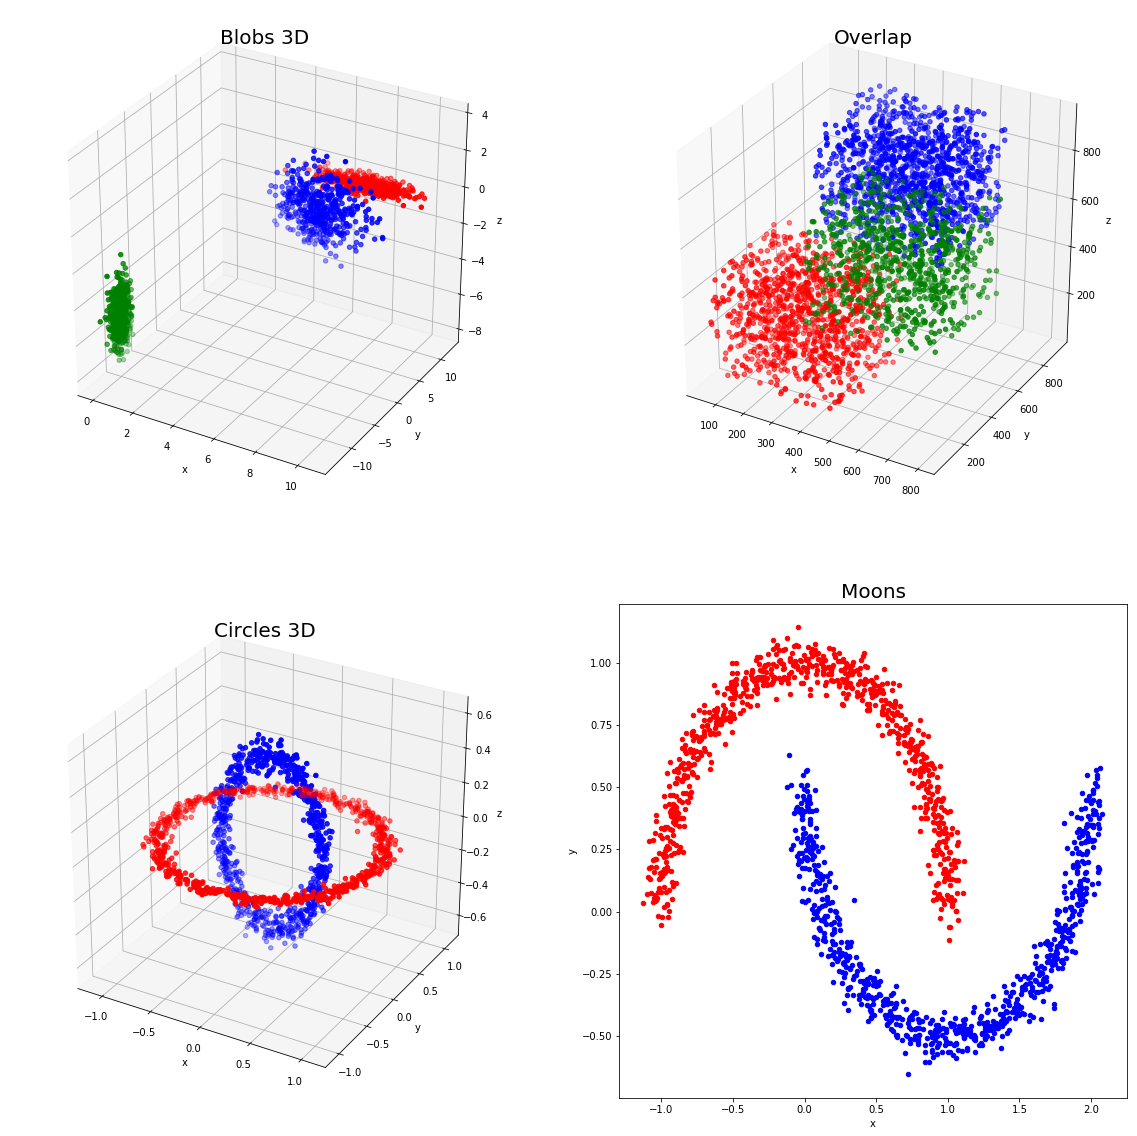

In [60]:
colors = {0:'red', 1:'blue', 2:'green'}
fig = plt.figure(figsize=(20,20))
    
#blobs
ax1 = fig.add_subplot(221, projection='3d')
grouped = df_blobs.groupby('cluster')

i = 0
for key, group in grouped:
    ax1.scatter(group['x'], group['y'], group['z'], color=colors[i])
    i = i + 1       
ax1.set_title('Blobs 3D', fontdict=fontdict)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

#overlap
ax2 = fig.add_subplot(222, projection='3d')
grouped = df_overlap.groupby('cluster')

i = 0
for key, group in grouped:
    ax2.scatter(group['x'], group['y'], group['z'], color=colors[i])
    i = i + 1
ax2.set_title('Overlap', fontdict=fontdict)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
    
#circles
ax3 = fig.add_subplot(223, projection='3d')
grouped = df_circles.groupby('cluster')

i = 0
for key, group in grouped:
    ax3.scatter(group['x'], group['y'], group['z'], color=colors[i])
    i = i + 1       
ax3.set_title('Circles 3D', fontdict=fontdict)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
    
#moons
ax4 = fig.add_subplot(224)
grouped = df_moons.groupby('cluster')
i = 0
for key, group in grouped:
    group.plot(ax=ax4, kind='scatter', x='x', y='y', color=colors[i])
    i = i + 1
ax4.set_title('Moons', fontdict=fontdict)

# 2. Plot data

Visualize data if they have 2 or 3 features.

In [18]:
grouped = df.groupby('cluster')
for group in grouped:
    print(group)

(0,              x         y    z  cluster
0    -0.677999 -0.698757  0.0        0
1     0.931437  0.191391  0.0        0
3     0.872837  0.375023  0.0        0
6     0.935534 -0.069950  0.0        0
7     0.159219  0.971415  0.0        0
8    -0.611547  0.751418  0.0        0
13   -0.104486  0.942077  0.0        0
14    0.967687 -0.174183  0.0        0
15    0.754242 -0.621617  0.0        0
18   -1.027807  0.155325  0.0        0
20    0.071758  0.989000  0.0        0
21    0.655803 -0.812775  0.0        0
22    0.758490  0.629618  0.0        0
23   -0.866656 -0.497841  0.0        0
27   -0.184218 -0.921755  0.0        0
31   -0.850261  0.502583  0.0        0
36   -0.603595 -0.675230  0.0        0
37    0.120921 -0.969693  0.0        0
38   -0.699461 -0.700145  0.0        0
39   -0.829813  0.384497  0.0        0
43    0.738477 -0.657938  0.0        0
44   -0.615457  0.768498  0.0        0
45   -0.378752 -0.893043  0.0        0
47    0.940516 -0.345081  0.0        0
52    0.053183 -0.948

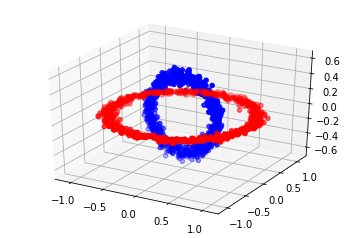

In [15]:
colors = {0:'red', 1:'blue', 2:'green'}

if (df.columns.size == 3):
    fix, ax = plt.subplots()
    grouped = df.groupby('cluster')
    
    i = 0
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y',
                   label=key, color=colors[i])
        i = i + 1
    plt.show()
elif (df.columns.size == 4):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    grouped = df.groupby('cluster')

    i = 0
    for key, group in grouped:
        ax.scatter(group['x'], group['y'], group['z'], color=colors[i])
        i = i + 1
    plt.show()
else:
    print("There is no good visualisation for this dataset - " + str(df.columns.size) + " features.")
    

In [5]:
#creating test datasets
names = set(df['cluster'])

dataframes = {}
for name in names:
    tmp_df = df[df['cluster'] == name]
    dataframes[name] = butils.TestDf(tmp_df)
    
#all data for testing
full_test_df = pd.DataFrame()

for name in names:
    full_test_df = full_test_df.append(dataframes[name].test_df)

In [6]:
def benchmark_result_plots(matrices, titles, headers, rotation_num):
    """
    parameters:
    matrices - list of 2d np.array
    titles - list of graph titles
    names - list of labels
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
    ax_list = [ax1, ax2, ax3, ax4]

    for index in range(0, len(matrices)):
        tick_labels = list(headers[index])
        ax = ax_list[index]
        ax.imshow(matrices[index], cmap='binary')

        # We want to show all ticks...
        ax.set_xticks(np.arange(len(tick_labels)))
        ax.set_yticks(np.arange(len(tick_labels)))

        # ... and label them with the respective list entries
        ax.set_xticklabels(tick_labels)
        ax.set_yticklabels(tick_labels)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), ha="right")

        # Loop over data dimensions and create text annotations.
        for i in range(len(tick_labels)):
            for j in range(len(tick_labels)):
                if(matrices[index][i, j] == 0):
                    continue
                if i == j:
                    text = ax.text(j, i, matrices[index][i, j], ha="center", va="center", color="g",
                                   weight="bold", fontsize=16)
                    continue
                else:
                    text = ax.text(j, i, matrices[index][i, j], ha="center", va="center", color = "r",
                                   weight="bold", fontsize=16)
            
        ax.set_title(titles[index], fontsize=16)
    plt.savefig('experiments/exp3/mfeat_pix_' + str(rotation_num) + '.png')
        

Cluster     |Full        |Greedy      |One Shot    |Delta Medoids|Random Select
-------------------------------------------------------------------------------
0           |160         |32          |30          |16          |16          
1           |160         |48          |49          |16          |16          
2           |160         |44          |46          |15          |15          
3           |160         |63          |65          |14          |14          
4           |160         |39          |44          |15          |15          
5           |160         |70          |69          |12          |12          
6           |160         |51          |51          |13          |13          
7           |160         |19          |18          |11          |11          
8           |160         |70          |73          |13          |13          
9           |160         |44          |42          |15          |15          
Full Medoids
              precision    recall  f1-score   s

/home/hlavaj20/miniconda3/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


              precision    recall  f1-score   support

           0       0.88      0.95      0.92        40
           1       0.90      0.93      0.91        40
           2       0.97      0.95      0.96        40
           3       0.90      0.95      0.93        40
           4       0.93      0.95      0.94        40
           5       0.92      0.90      0.91        40
           6       0.97      0.93      0.95        40
           7       0.90      0.90      0.90        40
           8       0.95      0.88      0.91        40
           9       0.93      0.93      0.93        40

   micro avg       0.93      0.93      0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400

Greedy Selection
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.95      0.97        40
           2       0.97      0.95      0.96        40
       

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        40
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        40
           8       1.00      0.97      0.99        40
           9       1.00      1.00      1.00        40

   micro avg       1.00      1.00      1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Rates for each method:
greedy_select: 0.00250626566416
one_shot_medoids: 0.0
random_select: 0.108033240997
full_medoids: 0.0526315789474
Method that got the best result is full_medoids
Creating plots.


Dataset Rotated!

Cluster     |Full   

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        40
           6       1.00      1.00      1.00        40
           7       1.00      0.97      0.99        40
           8       1.00      1.00      1.00        40
           9       0.98      1.00      0.99        40

   micro avg       1.00      1.00      1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Rates for each method:
greedy_select: 0.00250626566416
one_shot_medoids: 0.00250626566416
random_select: 0.078167115903
full_medoids: 0.078167115903
Method that got the best result is full_medoids
Creating plots.


Dataset Rotated!



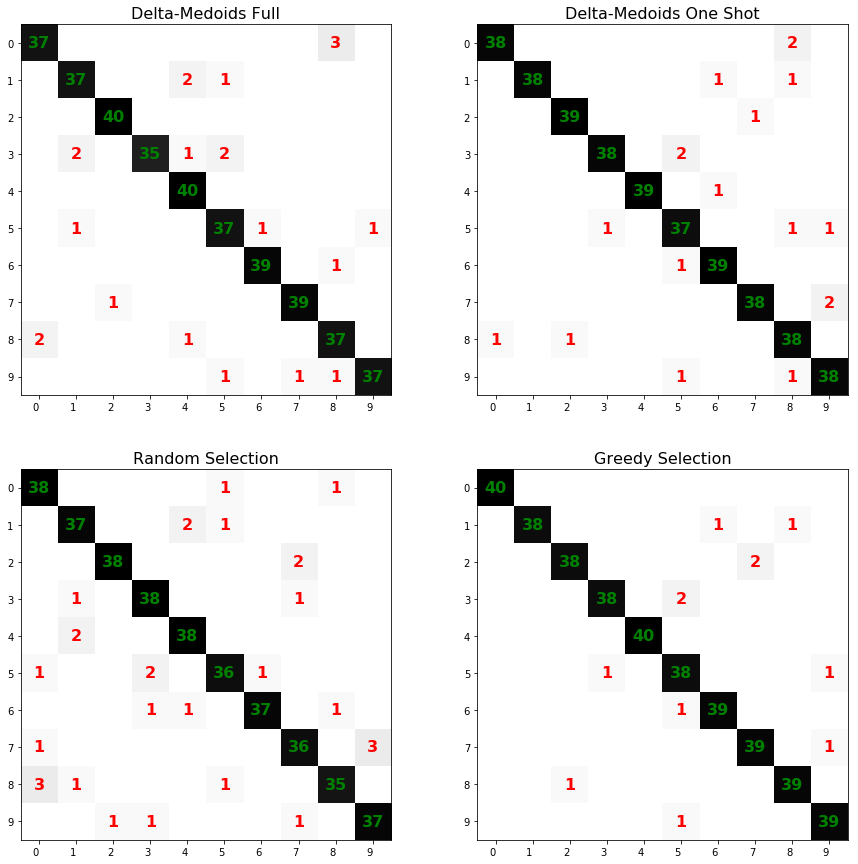

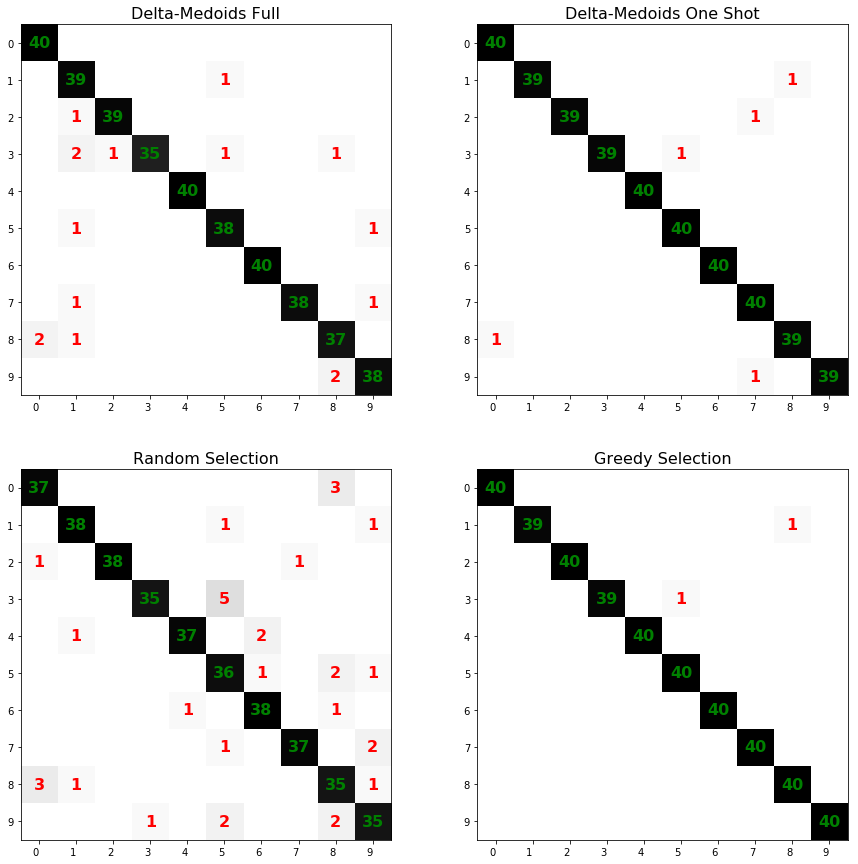

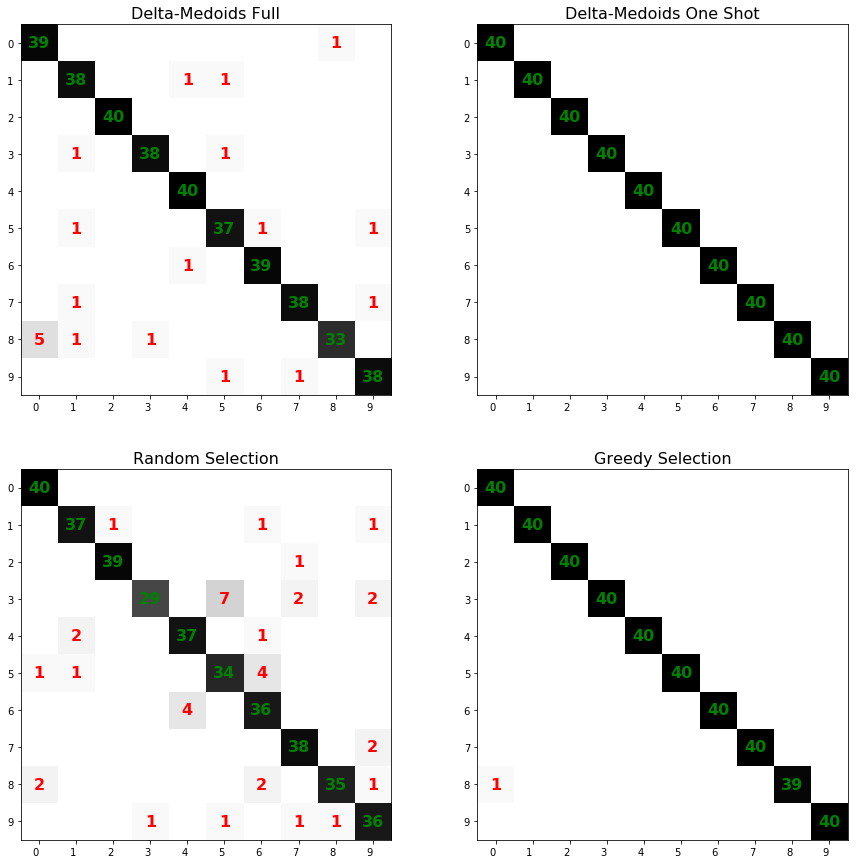

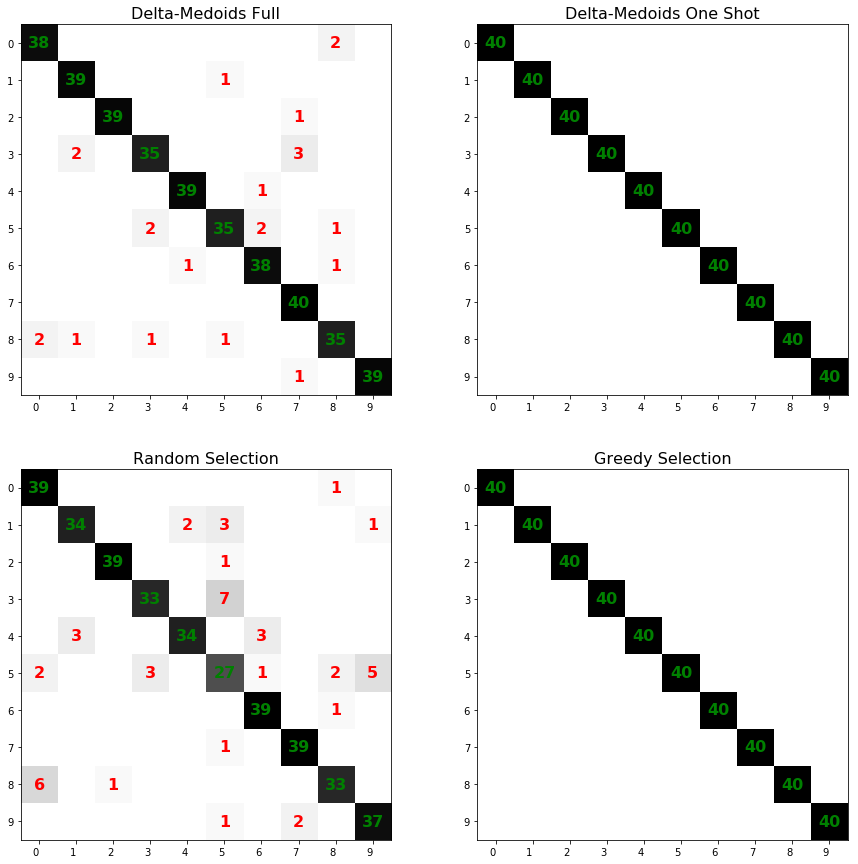

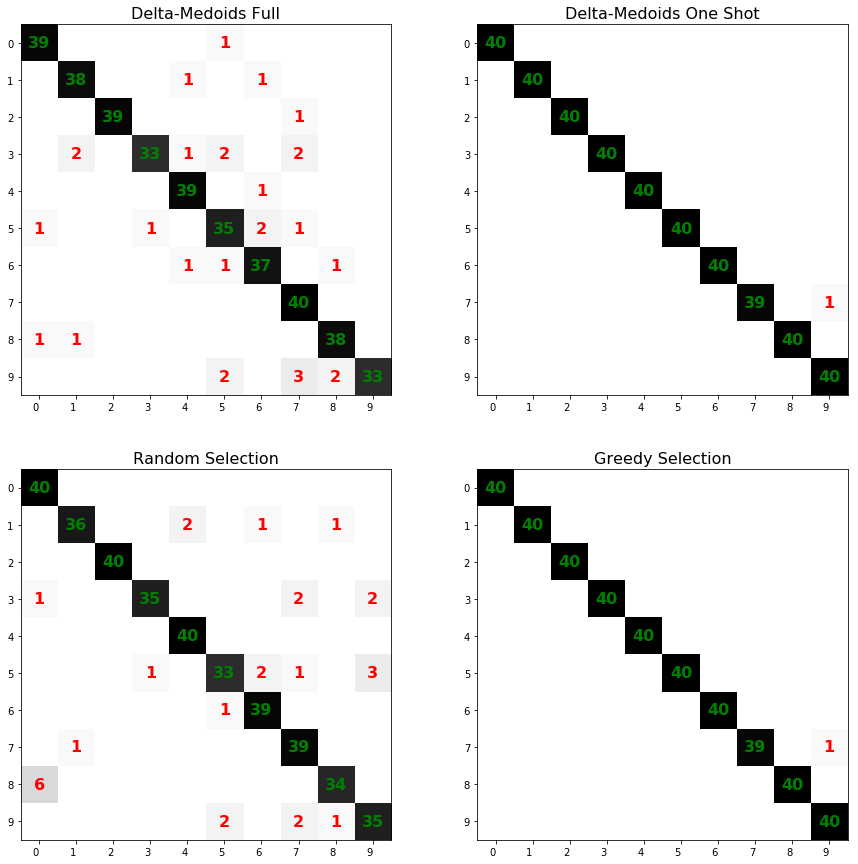

In [7]:
for i in range(0,5):
    matrices = butils.get_method_results(full_test_df, dataframes, distance.euclidean, None)

    matrix_full = matrices[0]
    matrix_one_shot = matrices[1]
    matrix_random_selection = matrices[2]
    matrix_greedy_select = matrices[3]

    precision_results = {"full_medoids" : butils.get_hit_miss_rate(matrix_full),
                         "one_shot_medoids" : butils.get_hit_miss_rate(matrix_one_shot),
                         "random_select" : butils.get_hit_miss_rate(matrix_random_selection),
                         "greedy_select" : butils.get_hit_miss_rate(matrix_greedy_select)}

    print("Rates for each method:")
    evaluation_sum = 0
    minimal_rate = ""
    for key in precision_results:
        print(key + ": " + str(precision_results[key]))
        if precision_results[key] < minimal_rate:
            minimal_rate = key
        
    print("Method that got the best result is " + minimal_rate)
    evaluation_sum = evaluation_sum + precision_results[minimal_rate]
    
    print("Creating plots.")
    benchmark_result_plots([matrix_full, matrix_one_shot, matrix_random_selection, matrix_greedy_select],
                       ['Delta-Medoids Full', 'Delta-Medoids One Shot', 'Random Selection', 'Greedy Selection'],
                       [names, names, names, names], i)
    
    for key in dataframes:
        dataframes[key].rotate()
    print("\n\nDataset Rotated!\n")

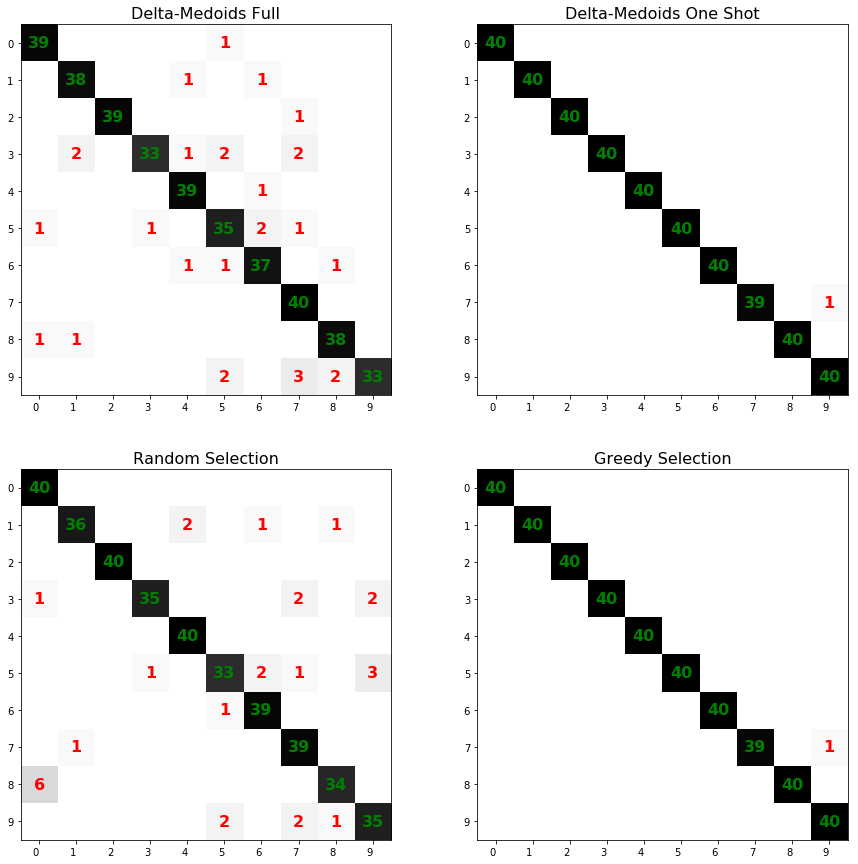

In [8]:
benchmark_result_plots([matrix_full, matrix_one_shot, matrix_random_selection, matrix_greedy_select],
                       ['Delta-Medoids Full', 'Delta-Medoids One Shot', 'Random Selection', 'Greedy Selection'],
                       [names, names, names, names], 100)

KeyError: 'x'

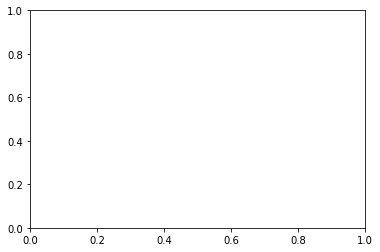

In [9]:
fix, ax = plt.subplots()

i = 0
df[df['cluster'] == 0].plot(ax=ax, kind='scatter', x='x', y='y',
              label=0, color='red')
plt.show()

In [ ]:
# this is the argmin calculation for delta_medoids_full algorithm
def find_best_cluster_representative(cluster, similarity_measure):
    #input: np.array(of points)
    #returns a tuple
    min_sum = float("inf")
    best_repr_index = None
    for i in range(len(cluster)):
        distance_sum = 0;
        for point in cluster:
            distance_sum += similarity_measure(cluster[i], point)
            if (distance_sum > min_sum):
                break
        if(distance_sum < min_sum):
            min_sum = distance_sum
            best_repr_index = i

    return cluster[best_repr_index]

def delta_medoids_full(df, delta, similarity_measure):

    t = 0 #iteration number
    representatives = {} #selected representatives
    representatives[t] = set() #representatives for given iteration
    size_threshold = 0.03 * len(df.index)

    while True:
        #print("\n=========== running for t = " + str(t) + "============")
        clusters = {} #subclusters inside cluster
        for item in representatives[t]:
            clusters[item] = np.array(item, ndmin=2)

        print 'clusters before rep assign', len(clusters.keys())
        t = t + 1

        #================== RepAssign starts ==================
        for row in df.iterrows():
            dist = float("inf")
            represenative = None

            point = tuple(row[1])

            for rep in clusters.keys():
                #finding the closest representative to current point
                if similarity_measure(point, rep) <= dist:
                    representative = rep
                    dist = similarity_measure(point, rep)
            if dist <= delta:
                clusters[representative] = np.vstack((clusters[representative], point))
            elif t == 1:
                clusters[point] = np.array(point, ndmin=2)
        #================== RepAssign ends ===================

        
        if (len(clusters.keys()) > 30) or (len(clusters.keys()) > len(df.index) * 0.05):
            for key in list(clusters.keys()):
                if len(clusters[key]) <= size_threshold:
                    tmp_sim = 0
                    max_sim = 0
                    new_key = key
                    for key_sim in list(clusters.keys()):
                        tmp_sim = similarity_measure(key, key_sim)
                        if key_sim == key:
                            continue
                        elif tmp_sim > max_sim:
                            new_key = key_sim
                            max_sim = tmp_sim
                
                    if new_key == key:
                        print('Dropping this cluster, it is not relevant.')
                    else:
                        clusters[new_key] = np.vstack((clusters[new_key], clusters[key]))
                    del(clusters[key])
                    print 'clusters in loop', len(clusters.keys())
        
        representatives[t] = set()
        print 'clusters out of loop', len(clusters.keys())
        for cluster in clusters.values():
            representative = find_best_cluster_representative(cluster, similarity_measure)
            #print(representative)
            representatives[t].add(tuple(representative))
        #print(representatives[t])

        if representatives[t] == representatives[t-1]:
            break

    #print("delta_medoids_full algorithm ended after " + str(t) + " iterations.")
    return pd.DataFrame(list(representatives[t]), columns=df.columns.values)

In [ ]:
#delta medoids full
dft = df[df['cluster'] == 0]
dta = butils.estimate_delta(dft, distance.euclidean)
medoids_full_result = delta_medoids_full(dft, dta, distance.euclidean)
one_shot_medoids_result = butils.delta_medoids_one_shot(dft, dta, distance.euclidean)
# test_res["delta_medoids_full"][name] = medoids_full_result
# train_delta_medoids_full = train_delta_medoids_full.append(medoids_full_result)

In [ ]:
fix, ax = plt.subplots()

i = 0
dft.plot(ax=ax, kind='scatter', x='x', y='y',label=0, color='red', s=50)
medoids_full_result.plot(ax=ax, kind='scatter', x='x', y='y',label='medoids', color='blue', figsize=(20,20), s=150)
plt.show()

In [ ]:
fix, ax = plt.subplots()

i = 0
dft.plot(ax=ax, kind='scatter', x='x', y='y',label=0, color='red', s=50)
one_shot_medoids_result.plot(ax=ax, kind='scatter', x='x', y='y',label='medoids', color='blue', figsize=(20,20), s=150)
plt.show()